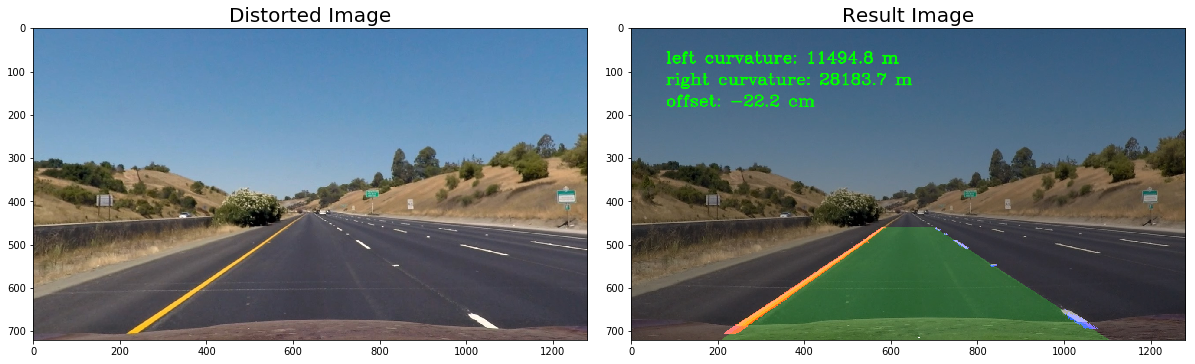

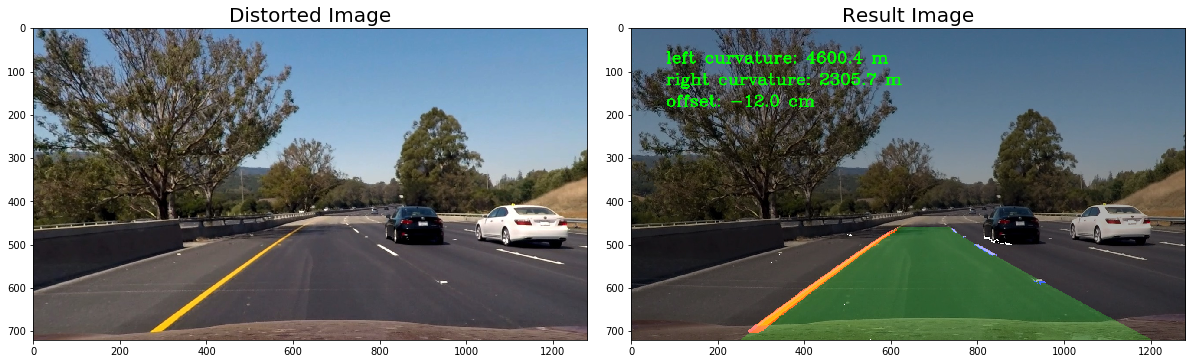

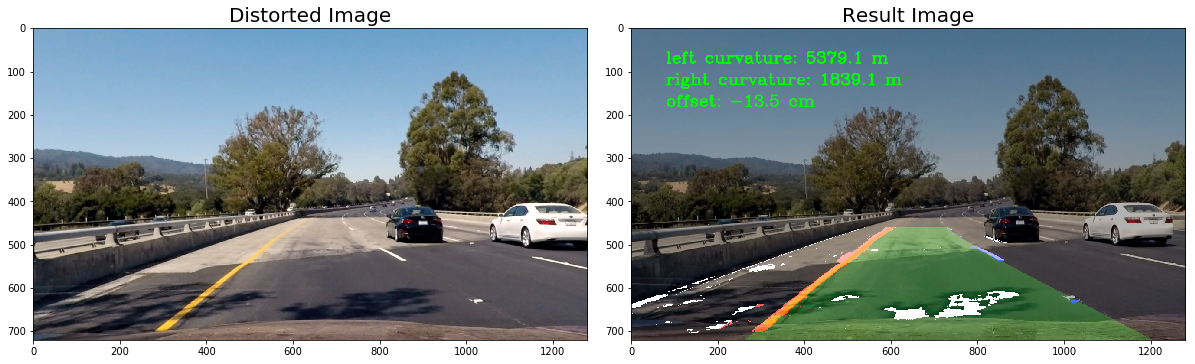

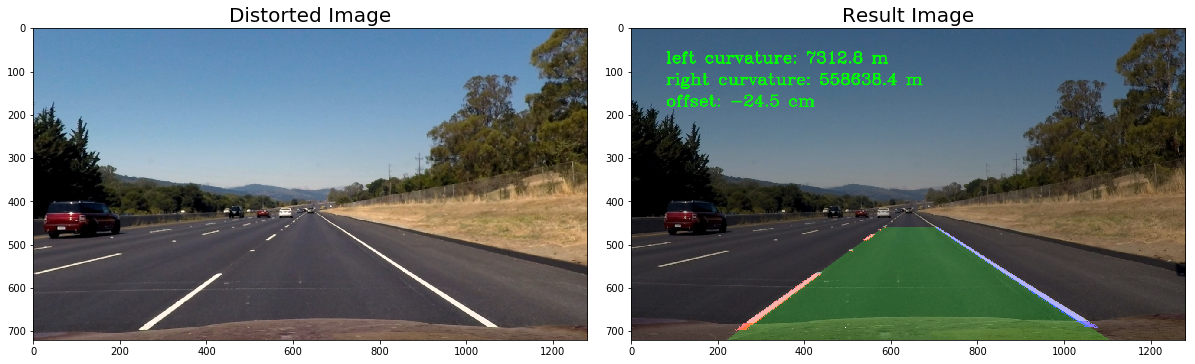

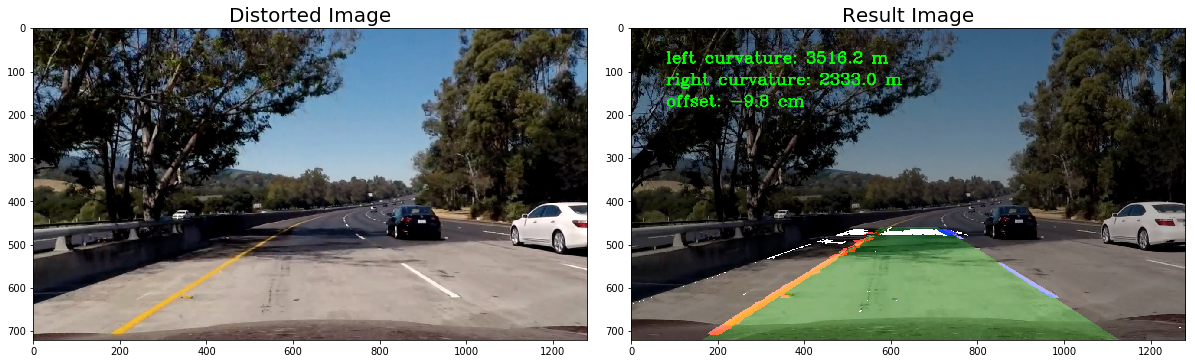

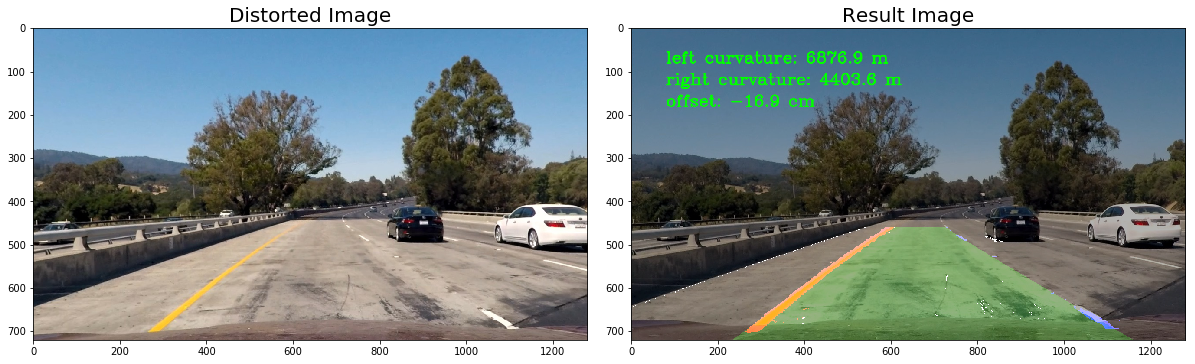

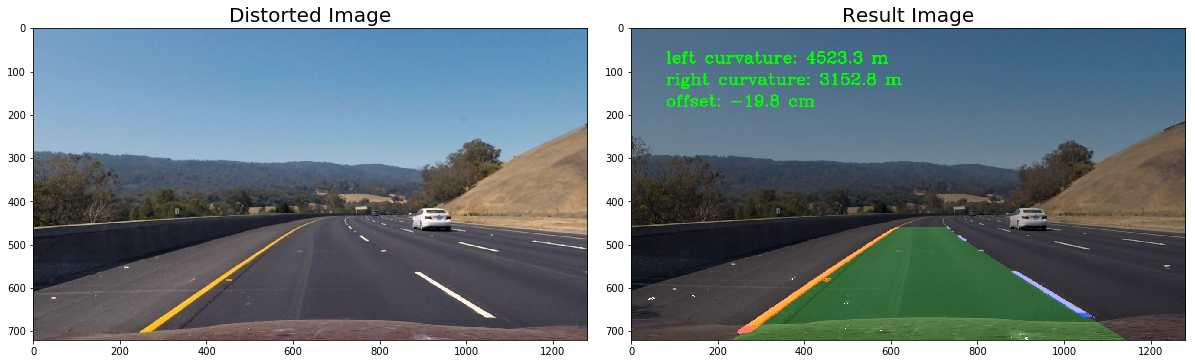

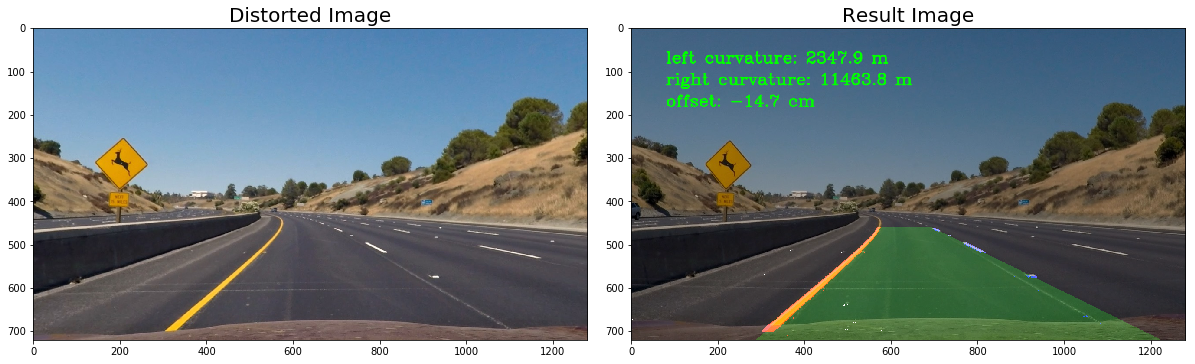

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os


# Define a function that applies Sobel x or y,
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img_gray, orint='x', sobel_kernel=3, abs_thresh=(0, 255)):
    if 'x' == orint:
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif 'y' == orint:
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        print('illegal direction!')
        return
    abs_sobel = np.absolute(sobel)
    scale_sobel = np.uint8(abs_sobel * 255 / np.max(abs_sobel))
    img_binary = np.zeros_like(img_gray)
    img_binary[(scale_sobel >= abs_thresh[0]) & (scale_sobel <= abs_thresh[1])] = 1
    return img_binary


# Define a function that applies Sobel x and y, then computes the
# magnitude of the gradient and applies a threshold
def mag_thresh(img_gray, sobel_kernel=3, mag_thresh=(0, 255)):
    xsobel = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    ysobel = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobel = np.sqrt(xsobel * xsobel + ysobel * ysobel)
    factor = np.max(mag_sobel)
    mag_sobel = (mag_sobel * 255 / factor).astype(np.uint8)
    img_binary = np.zeros_like(img_gray)
    img_binary[(mag_sobel >= mag_thresh[0]) & (mag_sobel <= mag_thresh[1])] = 1
    return img_binary


# Define a function that applies Sobel x and y,
# then computes the direction of the gradient
def dir_thresh(img_gray, sobel_kernel=3, dir_thresh=(0, np.pi / 2)):
    xsobel = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    ysobel = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    dir_sobel = np.arctan2(np.absolute(ysobel), np.absolute(xsobel))
    img_binary = np.zeros_like(img_gray)
    img_binary[(dir_sobel >= dir_thresh[0]) & (dir_sobel <= dir_thresh[1])] = 1
    return img_binary


# Define a function that thresholds the channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_channel(img_origin, channel='h', thresh=(0, 255)):
    hls = cv2.cvtColor(img_origin, cv2.COLOR_RGB2HLS)
    if 'h' == channel:
        img_channel = hls[:, :, 0]
    elif 'l' == channel:
        img_channel = hls[:, :, 1]
    elif 's' == channel:
        img_channel = hls[:, :, 2]
    else:
        print('illegal image channel!')
        return
    # Threshold color channel
    img_binary = np.zeros_like(img_channel)
    img_binary[(img_channel > thresh[0]) & (img_channel <= thresh[1])] = 1
    return img_channel, img_binary


def combinations_binary(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    xsobel_binary = abs_sobel_thresh(img_gray, 'x', 3, (40, 100))
    ysobel_binary = abs_sobel_thresh(img_gray, 'y', 3, (20, 120))
    mag_binary = mag_thresh(img_gray, 3, (30, 100))
    dir_binary = dir_thresh(img_gray, 15, (0.7, 1.3))
    l_channel, l_binary = hls_channel(img, 'l', (200, 255))
    s_channel, s_binary = hls_channel(img, 's', (90, 255))

    combined_binary = np.zeros_like(img_gray)
    combined_binary[(xsobel_binary == 1) |
                    (l_binary == 1) |
                    (s_binary == 1)] = 255

    return combined_binary


# Apply a perspective transform to rectify binary image ("birds-eye view").
def warper(img, src, dst):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    return warped


# Finding the Lines
def find_lane_pixels(img_warped):
    # Take a histogram of the bottom half of the image
    bottom_half = img_warped[img_warped.shape[0] // 2:, :]
    histogram = np.sum(bottom_half, axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img_warped, img_warped, img_warped))

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    left_base = np.argmax(histogram[0: midpoint])
    right_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img_warped.nonzero()
    nonzeroy = np.array(nonzero[0])  # y-coordinate of nonzero points
    nonzerox = np.array(nonzero[1])  # x-coordinate of nonzero points

    # Current positions to be updated later for each window in nwindows
    leftx_current = left_base
    rightx_current = right_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_warped.shape[0] - (window + 1) * window_height
        win_y_high = img_warped.shape[0] - window * window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                      (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),
                      (win_xright_high, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzerox >= win_xleft_low) &
                          (nonzerox <= win_xleft_high) &
                          (nonzeroy >= win_y_low) &
                          (nonzeroy <= win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) &
                           (nonzerox <= win_xright_high) &
                           (nonzeroy >= win_y_low) &
                           (nonzeroy <= win_y_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window
        #  (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def process_image(img_origin, img_warped, src, dst):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, _ = find_lane_pixels(img_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_warped.shape[0] - 1, img_warped.shape[0])
    try:
        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    except:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1 * ploty ** 2 + 1 * ploty
        right_fitx = 1 * ploty ** 2 + 1 * ploty

    # Calculate the radius of curvature based on pixel values
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2 * left_fit[0] * y_eval + left_fit[1]) ** 2) ** (3 / 2)) / (2 * np.abs(left_fit[0]))
    right_curverad = ((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** (3 / 2)) / (2 * np.abs(right_fit[0]))

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Calculate the radius of curvature based on real world
    y_eval = np.max(ploty) * ym_per_pix
    left_curverad = ((1 + (2 * left_fit[0] * y_eval + left_fit[1]) ** 2) ** (3 / 2)) / (2 * np.abs(left_fit[0]))
    right_curverad = ((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** (3 / 2)) / (2 * np.abs(right_fit[0]))

    # Calculate the offset from center
    y_pos = img_warped.shape[0]
    base_left = left_fit[0] * y_pos * y_pos + left_fit[1] * y_pos + left_fit[2]
    base_right = right_fit[0] * y_pos * y_pos + right_fit[1] * y_pos + right_fit[2]
    car_pos = img_warped.shape[0] / 2
    offset = ((base_right - base_left) / 2 - car_pos) * xm_per_pix


    #################################################################
    # Warp the detected lane boundaries back onto the original image.
    left_pos = np.array([left_fitx, ploty]).T
    right_pos = np.array([right_fitx, ploty]).T
    right_pos = np.flipud(right_pos)
    pos = np.vstack((left_pos, right_pos))

    # color lane area
    color_area = np.dstack((img_warped, img_warped, img_warped))
    cv2.fillPoly(color_area, np.int_([pos]), (0, 255, 0))

    # color lane line
    color_lane = np.dstack((img_warped, img_warped, img_warped))
    # Color in left and right line pixels
    color_lane[lefty, leftx] = [255, 0, 0]
    color_lane[righty, rightx] = [0, 0, 255]

    # Warp the detected lane boundaries back onto the original image.
    newwarp1 = warper(color_area, dst, src)
    newwarp2 = warper(color_lane, dst, src)
    result = cv2.addWeighted(img_origin, 1, newwarp1, 0.3, 0)
    result = cv2.addWeighted(result, 0.7, newwarp2, 1., 0)

    # Add text
    cv2.putText(result, 'left curvature: ' + str(round(left_curverad, 1)) + ' m',
                (80, 80), cv2.FONT_HERSHEY_COMPLEX, 1.2, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(result, 'right curvature: ' + str(round(right_curverad, 1)) + ' m',
                (80, 130), cv2.FONT_HERSHEY_COMPLEX, 1.2, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(result, 'offset: ' + str(round(offset * 100., 1)) + ' cm',
                (80, 180), cv2.FONT_HERSHEY_COMPLEX, 1.2, (0, 255, 0), 2, cv2.LINE_AA)

    return result


# TODO 1. Provide an example of a distortion-corrected image.
def main_image():
    mtx_dist__pickle = pickle.load(open("mtx_dist_pickle.p", "rb"))
    mtx = mtx_dist__pickle["mtx"]
    dist = mtx_dist__pickle["dist"]
    src = np.float32([[582, 460], [205, 720], [1108, 720], [700, 460]])
    dst = np.float32([[320, 0], [320, 720], [960, 720], [960, 0]])

    # distortion-corrected image
    for img_name in os.listdir('test_images/'):
        image = mpimg.imread('test_images/' + img_name)

        # Undistorting the image:
        image_undist = cv2.undistort(image, mtx, dist, None, mtx)
        # Create a thresholded binary image.
        image_binary = combinations_binary(image_undist)
        # Perspective transform
        image_warped = warper(image_binary, src, dst)
        # Finding the lane line, calculate the curvature of lane lines and vehicle position
        image_result = process_image(image, image_warped, src, dst)

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
        f.tight_layout()
        ax1.imshow(image_undist)
        ax1.set_title('Distorted Image', fontsize=20)
        ax2.imshow(image_result)
        ax2.set_title('Result Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


if __name__ == '__main__':
    main_image()
